In [122]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [123]:
import sys
sys.path.append('/gdrive/My Drive/2nd Sem/IBM/Covid Project/Code/Scraping Twitter Data')

In [124]:
pip install googletrans

In [151]:
import private
import re
import tweepy
import difflib
import pandas as pd
import numpy as np
import pickle
import copy
from googletrans import Translator
import matplotlib.pyplot as plt


from datetime import date

In [152]:
auth = tweepy.OAuthHandler(private.CONSUMER_KEY, private.CONSUMER_SECRET)
auth.set_access_token(private.OAUTH_TOKEN, private.OAUTH_TOKEN_SECRET)
api = tweepy.API(auth)

In [153]:
# tweet_id  = "1275848474987311107"
tweet_id = "1261004897790517248"
tweet = api.get_status(tweet_id,tweet_mode='extended')

In [154]:
def calculate_days_past(tweet_time):
    #Calculating Dates
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    a1 = int(tweet_time[-1])
    b1 = int(months.index(tweet_time[1])+1)
    c1 = int(tweet_time[2])

    #Todays date
    today = date.today()
    life  =  str(date(today.year,today.month,today.day) - date(a1,b1,c1))
    if(len(life)>7):
        life  = life.split(" ")
        life  = life[0]
        life  = int(life)
        return life
    else:
        return 0

In [155]:
def get_user_info(tweet):
    
    tweet_text   = tweet.full_text
    real_name    = tweet._json['user']['name']
    user_handle  = tweet._json['user']['screen_name']
    tweet_id     = tweet._json['id']
    user_id      = tweet._json['user']['id']
    
    user_info = api.get_user(user_id,user_mode='extended')
    desc = user_info._json['description']
    
    try:
        expanded_url = user_info._json['entities']['url']['urls'][0]['expanded_url']
        expanded_url = 1
    except:
        expanded_url = 0

    
    chars_in_desc          = len(desc)
    chars_in_real_name     = len(real_name)
    chars_in_user_handle   = len(user_handle)
    num_matches            = len(difflib.SequenceMatcher(None, real_name,user_handle).get_matching_blocks())
    total_urls_in_desc     = len(user_info._json['entities']['description']['urls'])
    official_url_exists    = expanded_url
    followers_count        = user_info._json['followers_count']
    friends_count          = user_info._json['friends_count']
    listed_count           = user_info._json['listed_count']
    favourites_count       = user_info._json['favourites_count']
    geo_enabled            = int(user_info._json['geo_enabled'])
    acc_created_on         = user_info._json['created_at'].split()
    acc_life               = calculate_days_past(acc_created_on)
    verified               = int(user_info._json['verified'])
    num_tweets             = user_info._json['statuses_count']
    protected              = int(user_info._json['protected'])
    posting_frequency      = num_tweets/acc_life
    latest_tweet_time      = user_info._json['status']['created_at'].split()
    activity               = calculate_days_past(latest_tweet_time)
    avg_likes_per_tweet    = favourites_count/num_tweets
    follower_friends_ratio = followers_count/friends_count
    
    list = [tweet_text, desc, real_name,
            user_handle, user_id, tweet_id,
            chars_in_desc, chars_in_real_name,
            chars_in_user_handle, num_matches,
            total_urls_in_desc, official_url_exists,
            followers_count, friends_count,
            listed_count, favourites_count,
            geo_enabled, acc_created_on,
            acc_life, verified, num_tweets,
            protected, posting_frequency,
            latest_tweet_time, activity,
            avg_likes_per_tweet, follower_friends_ratio]
    
    # for item in list:
        # print(item)
        
    return list

In [156]:
user_info = get_user_info(tweet)

In [12]:
path = r"/gdrive/My Drive/2nd Sem/IBM/Covid Project/Dataset/Infodemic/data/covid19_disinfo_data/English/covid19_infodemic_english_data.tsv"
df = pd.read_csv(path,sep='\t')
df = df.drop(['q2_label', 'q3_label', 'q4_label', 'q5_label', 'q6_label', 'q7_label'], axis=1)
df = df.rename(columns={'q1_label': 'Has_Verifiable_Claim'})
df

,tweet_id,text,Has_Verifiable_Claim
0,1241025578527903750,For the average American the best way to tell ...,no
1,1240467080954228737,this is fucking bullshit,no
2,1240716889162018816,Can y’all please just follow the government’s ...,no
3,1241062514886090754,No offense but the corona virus disappearing b...,no
4,1241447017945223169,This is the face of someone who just spent 9 h...,yes
...,...,...,...
499,1235967176475111432,President Trump's comments about the coronavir...,yes
500,1236056191324864515,Drug companies reportedly killed a provision i...,yes
501,1235987075440283648,Does @twitter have a team fighting covid-19 ru...,no
502,1235959558058754048,#FOX to cause PANDEMIC #FoxNews is spreading ...,yes


In [13]:
def preprocess_tweet(tweet_id, tweet):

    ### Structure of the list returned should look like this
    ### [tweet_id, cleaned_tweet, length_before, length_after, ratio_of_length, number_of_upper_chars, has_question_marks, number_of_question_marks, has_exclamations, number_of_exclamation_marks]

    final_tweet = []

    length_before               = len(tweet)
    number_of_upper_chars       = 0
    number_of_question_marks    = 0
    number_of_exclamation_marks = 0

    for ch in tweet:
        number_of_upper_chars         += int(ch.isupper())
        number_of_question_marks      += int(ch == '?')
        number_of_exclamation_marks   += int(ch == '!')

    has_question_marks    = int(number_of_question_marks>0)
    has_exclamation_marks = int(number_of_exclamation_marks>0)


    tweet = tweet.lower()
    url = r'http\S+'
    tweet = re.sub(url, 'URL', tweet, flags=re.MULTILINE)
    emoji = re.compile("["         u"\U0001F600-\U0001F64F"  # emoticons
                                   u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                   u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                   u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                   u"\U00002500-\U00002BEF"  # chinese char
                                   u"\U00002702-\U000027B0"
                                   u"\U00002702-\U000027B0"
                                   u"\U000024C2-\U0001F251"
                                   u"\U0001f926-\U0001f937"
                                   u"\U00010000-\U0010ffff"
                                   u"\u2640-\u2642"
                                   u"\u2600-\u2B55"
                                   u"\u200d"
                                   u"\u23cf"
                                   u"\u23e9"
                                   u"\u231a"
                                   u"\ufe0f"  # dingbats
                                   u"\u3030"
                                   "]+", flags=re.UNICODE)
    tweet =  emoji.sub(r'', tweet)
    tweet = ' '.join([word[1:] if word[0] == '#' else word for word in tweet.split()])


    length_after = len(tweet)
    length_ratio = length_after/length_before

    final_tweet = [tweet_id, tweet, length_before, length_after, length_ratio, number_of_upper_chars,has_question_marks, number_of_question_marks, has_exclamation_marks, number_of_exclamation_marks]

    # for item in final_tweet:
        # print(item)

    return final_tweet
    


In [14]:
tweet = "Happy to collaborate with Jio Studios!!!!! on #Whatif????, a thrilling short film streaming now on @jiostudios and Maniesh Paul Youtube Channels. Also streaming on @JioCinema. Lockdown ka पालन करो, stay home stay safe this #Lockdown."
cleaned_tweet = preprocess_tweet(1261004897790517248,tweet)

In [15]:
def preprocess_df(df):
    text_features_list = []
    for id in range(len(df)):
        text_features = preprocess_tweet(df['tweet_id'][id],df['text'][id])
        text_features.append(int(df['Has_Verifiable_Claim'][id]=='yes'))
        text_features_list.append(text_features)

    text_features_df = pd.DataFrame(text_features_list, columns = [ 'tweet_id', 'cleaned_tweet', 'length_before', 'length_after', 'ratio_of_length',
                                                                    'number_of_upper_chars', 'has_question_marks', 'number_of_question_marks',
                                                                    'has_exclamations', 'number_of_exclamation_marks','label'])
    return text_features_df

In [16]:
df_text = preprocess_df(df)
df_text

,tweet_id,cleaned_tweet,length_before,length_after,ratio_of_length,number_of_upper_chars,has_question_marks,number_of_question_marks,has_exclamations,number_of_exclamation_marks,label
0,1241025578527903750,for the average american the best way to tell ...,134,134,1.000000,2,0,0,0,0,0
1,1240467080954228737,this is fucking bullshit,24,24,1.000000,0,0,0,0,0,0
2,1240716889162018816,can y’all please just follow the government’s ...,218,218,1.000000,7,1,1,1,1,0
3,1241062514886090754,no offense but the corona virus disappearing b...,72,72,1.000000,2,0,0,0,0,0
4,1241447017945223169,this is the face of someone who just spent 9 h...,292,270,0.924658,7,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
499,1235967176475111432,president trump's comments about the coronavir...,247,245,0.991903,5,0,0,0,0,1
500,1236056191324864515,drug companies reportedly killed a provision i...,275,254,0.923636,5,0,0,0,0,1
501,1235987075440283648,does @twitter have a team fighting covid-19 ru...,273,273,1.000000,3,0,0,0,0,0
502,1235959558058754048,fox to cause pandemic foxnews is spreading tru...,278,246,0.884892,51,0,0,0,0,1


In [17]:
df_en = copy.deepcopy(df_text)
df_hi = copy.deepcopy(df_text)
df_bn = copy.deepcopy(df_text)

In [27]:
translator = Translator()

In [28]:
df_hi['cleaned_tweet'] = df_hi['cleaned_tweet'].apply(lambda text : translator.translate(text, dest='hi').text)
df_hi

,tweet_id,cleaned_tweet,length_before,length_after,ratio_of_length,number_of_upper_chars,has_question_marks,number_of_question_marks,has_exclamations,number_of_exclamation_marks,label
0,1241025578527903750,औसत अमेरिकी के लिए यह बताने का सबसे अच्छा तरीक...,134,134,1.000000,2,0,0,0,0,0
1,1240467080954228737,यह बकवास है,24,24,1.000000,0,0,0,0,0,0
2,1240716889162018816,क्या आप कृपया सरकार के निर्देशों का पालन कर सक...,218,218,1.000000,7,1,1,1,1,0
3,1241062514886090754,"कोई अपराध नहीं है, लेकिन अप्रैल से पहले गायब ह...",72,72,1.000000,2,0,0,0,0,0
4,1241447017945223169,"यह किसी ऐसे व्यक्ति का चेहरा है, जिसने केवल व्...",292,270,0.924658,7,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
499,1235967176475111432,president trump's comments about the coronavir...,247,245,0.991903,5,0,0,0,0,1
500,1236056191324864515,drug companies reportedly killed a provision i...,275,254,0.923636,5,0,0,0,0,1
501,1235987075440283648,does @twitter have a team fighting covid-19 ru...,273,273,1.000000,3,0,0,0,0,0
502,1235959558058754048,fox to cause pandemic foxnews is spreading tru...,278,246,0.884892,51,0,0,0,0,1


In [29]:
df_bn['cleaned_tweet'] = df_bn['cleaned_tweet'].apply(lambda text : translator.translate(text, dest='bn').text)
df_bn

,tweet_id,cleaned_tweet,length_before,length_after,ratio_of_length,number_of_upper_chars,has_question_marks,number_of_question_marks,has_exclamations,number_of_exclamation_marks,label
0,1241025578527903750,for the average american the best way to tell ...,134,134,1.000000,2,0,0,0,0,0
1,1240467080954228737,this is fucking bullshit,24,24,1.000000,0,0,0,0,0,0
2,1240716889162018816,can y’all please just follow the government’s ...,218,218,1.000000,7,1,1,1,1,0
3,1241062514886090754,no offense but the corona virus disappearing b...,72,72,1.000000,2,0,0,0,0,0
4,1241447017945223169,this is the face of someone who just spent 9 h...,292,270,0.924658,7,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
499,1235967176475111432,president trump's comments about the coronavir...,247,245,0.991903,5,0,0,0,0,1
500,1236056191324864515,drug companies reportedly killed a provision i...,275,254,0.923636,5,0,0,0,0,1
501,1235987075440283648,does @twitter have a team fighting covid-19 ru...,273,273,1.000000,3,0,0,0,0,0
502,1235959558058754048,fox to cause pandemic foxnews is spreading tru...,278,246,0.884892,51,0,0,0,0,1


In [30]:
#drop rows with english text
idx_drop_bn = [index for index, row in df_bn.iterrows() if translator.detect(row['cleaned_tweet']).lang == 'en']
idx_drop_hi = [index for index, row in df_hi.iterrows() if translator.detect(row['cleaned_tweet']).lang == 'en']


In [31]:
df_hindi_mod = df_hi.copy()
df_hindi_mod = df_hindi_mod.drop(idx_drop_hi)
print(len(df_hindi_mod))

256


In [32]:
df_bangla_mod = df_bn.copy()
df_bangla_mod = df_bangla_mod.drop(idx_drop_bn)
print(len(df_bangla_mod))

191


In [299]:
# #Dumping Text Features DataFrame

# path_temp = r"/gdrive/My Drive/2nd Sem/IBM/Covid Project/Dataset/Processed_Datasets/df_text_en.pkl"
# f = open(path_temp,'wb')
# pickle.dump(df_en,f)
# f.close()


# path_temp = r"/gdrive/My Drive/2nd Sem/IBM/Covid Project/Dataset/Processed_Datasets/df_text_hi.pkl"
# f = open(path_temp,'wb')
# pickle.dump(df_hi,f)
# f.close()


# path_temp = r"/gdrive/My Drive/2nd Sem/IBM/Covid Project/Dataset/Processed_Datasets/df_text_bn.pkl"
# f = open(path_temp,'wb')
# pickle.dump(df_bn,f)
# f.close()


# path_temp = r"/gdrive/My Drive/2nd Sem/IBM/Covid Project/Dataset/Processed_Datasets/df_text_hi_modified.pkl"
# f = open(path_temp,'wb')
# pickle.dump(df_hindi_mod,f)
# f.close()


# path_temp = r"/gdrive/My Drive/2nd Sem/IBM/Covid Project/Dataset/Processed_Datasets/df_text_bn_modified.pkl"
# f = open(path_temp,'wb')
# pickle.dump(df_bangla_mod,f)
# f.close()

In [131]:
#Loading Text Features DataFrame

path_temp = r"/gdrive/My Drive/2nd Sem/IBM/Covid Project/Dataset/Processed_Datasets/df_text_en.pkl"
f = open(path_temp,'rb')
df_en = pickle.load(f)
f.close()

path_temp = r"/gdrive/My Drive/2nd Sem/IBM/Covid Project/Dataset/Processed_Datasets/df_text_hi.pkl"
f = open(path_temp,'rb')
df_hi = pickle.load(f)
f.close()

path_temp = r"/gdrive/My Drive/2nd Sem/IBM/Covid Project/Dataset/Processed_Datasets/df_text_bn.pkl"
f = open(path_temp,'rb')
df_bn = pickle.load(f)
f.close()

path_temp = r"/gdrive/My Drive/2nd Sem/IBM/Covid Project/Dataset/Processed_Datasets/df_text_hi_modified.pkl"
f = open(path_temp,'rb')
df_hindi_mod = pickle.load(f)
f.close()

path_temp = r"/gdrive/My Drive/2nd Sem/IBM/Covid Project/Dataset/Processed_Datasets/df_text_bn_modified.pkl"
f = open(path_temp,'rb')
df_bangla_mod = pickle.load(f)
f.close()

In [34]:
df_en

,tweet_id,cleaned_tweet,length_before,length_after,ratio_of_length,number_of_upper_chars,has_question_marks,number_of_question_marks,has_exclamations,number_of_exclamation_marks,label
0,1241025578527903750,for the average american the best way to tell ...,134,134,1.000000,2,0,0,0,0,0
1,1240467080954228737,this is fucking bullshit,24,24,1.000000,0,0,0,0,0,0
2,1240716889162018816,can y’all please just follow the government’s ...,218,218,1.000000,7,1,1,1,1,0
3,1241062514886090754,no offense but the corona virus disappearing b...,72,72,1.000000,2,0,0,0,0,0
4,1241447017945223169,this is the face of someone who just spent 9 h...,292,270,0.924658,7,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
499,1235967176475111432,president trump's comments about the coronavir...,247,245,0.991903,5,0,0,0,0,1
500,1236056191324864515,drug companies reportedly killed a provision i...,275,254,0.923636,5,0,0,0,0,1
501,1235987075440283648,does @twitter have a team fighting covid-19 ru...,273,273,1.000000,3,0,0,0,0,0
502,1235959558058754048,fox to cause pandemic foxnews is spreading tru...,278,246,0.884892,51,0,0,0,0,1


In [35]:
df_hi

,tweet_id,cleaned_tweet,length_before,length_after,ratio_of_length,number_of_upper_chars,has_question_marks,number_of_question_marks,has_exclamations,number_of_exclamation_marks,label
0,1241025578527903750,औसत अमेरिकी के लिए यह बताने का सबसे अच्छा तरीक...,134,134,1.000000,2,0,0,0,0,0
1,1240467080954228737,यह बकवास है,24,24,1.000000,0,0,0,0,0,0
2,1240716889162018816,क्या आप कृपया सरकार के निर्देशों का पालन कर सक...,218,218,1.000000,7,1,1,1,1,0
3,1241062514886090754,"कोई अपराध नहीं है, लेकिन अप्रैल से पहले गायब ह...",72,72,1.000000,2,0,0,0,0,0
4,1241447017945223169,"यह किसी ऐसे व्यक्ति का चेहरा है, जिसने केवल व्...",292,270,0.924658,7,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
499,1235967176475111432,कोरोनोवायरस मृत्यु दर के बारे में राष्ट्रपति ट...,247,245,0.991903,5,0,0,0,0,1
500,1236056191324864515,दवा कंपनियों ने कथित तौर पर कोरोना वायरस फंडिं...,275,254,0.923636,5,0,0,0,0,1
501,1235987075440283648,क्या @ वेटर के पास प्लेटफॉर्म @jack पर कोविद -...,273,273,1.000000,3,0,0,0,0,0
502,1235959558058754048,"महामारी फैलने का कारण लोमड़ी है, ट्रम्प के कोर...",278,246,0.884892,51,0,0,0,0,1


In [36]:
df_bn

,tweet_id,cleaned_tweet,length_before,length_after,ratio_of_length,number_of_upper_chars,has_question_marks,number_of_question_marks,has_exclamations,number_of_exclamation_marks,label
0,1241025578527903750,গড় আমেরিকার জন্য আপনার কোভিড -১৯ আছে কিনা তা ...,134,134,1.000000,2,0,0,0,0,0
1,1240467080954228737,এই বকশি বাজানো হয়,24,24,1.000000,0,0,0,0,0,0
2,1240716889162018816,আপনি কি দয়া করে কেবলমাত্র সরকারের নির্দেশাবলী...,218,218,1.000000,7,1,1,1,1,0
3,1241062514886090754,কোনও অপরাধ নয় তবে এপ্রিল আসলে সফল হওয়ার আগে ...,72,72,1.000000,2,0,0,0,0,0
4,1241447017945223169,এই এমন একজনের মুখ যিনি লন্ডনের আশেপাশের গুরুতর...,292,270,0.924658,7,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
499,1235967176475111432,president trump's comments about the coronavir...,247,245,0.991903,5,0,0,0,0,1
500,1236056191324864515,drug companies reportedly killed a provision i...,275,254,0.923636,5,0,0,0,0,1
501,1235987075440283648,does @twitter have a team fighting covid-19 ru...,273,273,1.000000,3,0,0,0,0,0
502,1235959558058754048,fox to cause pandemic foxnews is spreading tru...,278,246,0.884892,51,0,0,0,0,1


In [37]:
df_hindi_mod

,tweet_id,cleaned_tweet,length_before,length_after,ratio_of_length,number_of_upper_chars,has_question_marks,number_of_question_marks,has_exclamations,number_of_exclamation_marks,label
0,1241025578527903750,औसत अमेरिकी के लिए यह बताने का सबसे अच्छा तरीक...,134,134,1.000000,2,0,0,0,0,0
1,1240467080954228737,यह बकवास है,24,24,1.000000,0,0,0,0,0,0
2,1240716889162018816,क्या आप कृपया सरकार के निर्देशों का पालन कर सक...,218,218,1.000000,7,1,1,1,1,0
3,1241062514886090754,"कोई अपराध नहीं है, लेकिन अप्रैल से पहले गायब ह...",72,72,1.000000,2,0,0,0,0,0
4,1241447017945223169,"यह किसी ऐसे व्यक्ति का चेहरा है, जिसने केवल व्...",292,270,0.924658,7,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
495,1236012995408470017,एक छोटी सी समस्या को नकली संकट में बदलना चाहते...,275,230,0.836364,38,1,1,0,0,0
496,1235711139620753408,"ट्रम्प: कोरोना-फ्लू गंभीर नहीं है, अगर आपके पा...",278,275,0.989209,12,0,0,0,0,1
498,1235831463121059840,उदाहरण के लिए: जब ट्रम्प संख्याओं को लागू करता...,276,256,0.927536,8,0,0,0,0,0
501,1235987075440283648,क्या @ वेटर के पास प्लेटफॉर्म @jack पर कोविद -...,273,273,1.000000,3,0,0,0,0,0


In [38]:
df_bangla_mod

,tweet_id,cleaned_tweet,length_before,length_after,ratio_of_length,number_of_upper_chars,has_question_marks,number_of_question_marks,has_exclamations,number_of_exclamation_marks,label
105,1241111496039546882,"ভুল তথ্য, গুজব এবং সত্যিক ত্রুটির জন্য সজাগ থা...",137,116,0.846715,11,0,0,1,1,0
119,1240453761434148864,"দুঃখিত, এই সব ""প্রতারণা"" বলে আর ফিরে আসেনি। আম...",262,256,0.977099,8,0,0,0,0,0
120,1241935299833253891,গতকাল রাতে উত্তর দিল্লির বিজয় নগর এলাকায় মণি...,237,217,0.915612,14,0,0,0,0,1
121,1242115593383247873,"ভুয়া খবর ছদ্মবেশী ধ্রুব রাঠি বলেছিলেন: ""করোনা...",171,149,0.871345,11,1,1,0,0,1
122,1241842361472294915,এই ছবিটি @bbcworld দ্বারা কানো তে কোভিড ১৯ এর ...,275,229,0.832727,34,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
369,1236505833673879552,আমার প্রিয় শিক্ষার্থীদের কাছে: রিজলে কোভিড -১...,279,279,1.000000,13,0,0,0,0,1
370,1237219150931599362,কেভিন ম্যাকার্থি করোনার ভাইরাসকে চাইনিজ বলছেন ...,272,272,1.000000,8,0,0,0,0,1
373,1236887326753574912,look at the hospitals diagnosing covid-19. st....,232,232,1.000000,26,0,0,0,0,1
393,1236678669768093701,anong effect ng isang araw na suspension of cl...,276,275,0.996377,13,1,1,0,0,1


In [39]:
'''

    Model 1: BERT_CLS_Model
    Model 2: SBERT_NLI_Model
    Model 3: SBERT_NLI_STSB_Model
    Model 4: SRoberta_NLI_Model
    Model 5: SRobert_NLI_STSB_Model

'''

'\n\n    Model 1: BERT_CLS_Model\n    Model 2: SBERT_NLI_Model\n    Model 3: SBERT_NLI_STSB_Model\n    Model 4: SRoberta_NLI_Model\n    Model 5: SRobert_NLI_STSB_Model\n\n'

In [40]:
pip install sentence_transformers

     |████████████████████████████████| 61kB 2.7MB/s 
     |████████████████████████████████| 675kB 12.2MB/s 
     |████████████████████████████████| 3.8MB 19.5MB/s 
     |████████████████████████████████| 1.1MB 45.3MB/s 
     |████████████████████████████████| 890kB 45.7MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.2.6.1-cp36-none-any.whl size=74031 sha256=84fb0abb65bf789adbdfdef6432524ed291bbf9554c0e438ca1ec0a212419a52
  Stored in directory: /root/.cache/pip/wheels/d7/fa/17/2b081a8cd8b0a86753fb0e9826b3cc19f0207062c0b2da7008
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=fe4de46d88d73aef560b6c080c57240bfb643ffd9fd1208b529d6eb937d616bc
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


In [41]:
from sentence_transformers import SentenceTransformer

model_1 = SentenceTransformer('bert-base-nli-cls-token')
model_2 = SentenceTransformer('bert-base-nli-mean-tokens')
model_3 = SentenceTransformer('bert-base-nli-stsb-mean-tokens')
model_4 = SentenceTransformer('roberta-base-nli-mean-tokens')
model_5 = SentenceTransformer('roberta-base-nli-stsb-mean-tokens')
 

100%|██████████| 405M/405M [00:27<00:00, 14.8MB/s]
100%|██████████| 405M/405M [00:27<00:00, 14.5MB/s]
100%|██████████| 405M/405M [00:29<00:00, 13.9MB/s]
100%|██████████| 459M/459M [00:28<00:00, 16.4MB/s]
100%|██████████| 459M/459M [00:28<00:00, 16.0MB/s]


In [42]:
def get_embeddings(tweets,choice):

    if(choice==1):
        tweets = model_1.encode(tweets)
    elif(choice==2):
        tweets = model_2.encode(tweets)
    elif(choice==3):
        tweets = model_3.encode(tweets)
    elif(choice==4):
        tweets = model_4.encode(tweets)
    else:
        tweets = model_5.encode(tweets)

    return tweets

In [44]:
#Creating only text embeddings dataset

bert_cls_embeddings          = pd.DataFrame(get_embeddings(df_en['cleaned_tweet'],1))
sbert_nli_embeddings         = pd.DataFrame(get_embeddings(df_en['cleaned_tweet'],2))
sbert_nli_stsb_embeddings    = pd.DataFrame(get_embeddings(df_en['cleaned_tweet'],3))
roberta_nli_embeddings       = pd.DataFrame(get_embeddings(df_en['cleaned_tweet'],4))
roberta_nli_stsb_embeddings  = pd.DataFrame(get_embeddings(df_en['cleaned_tweet'],5))



bert_cls_embeddings_dataset           = pd.concat([df_en['tweet_id'], bert_cls_embeddings,         df_en['label']],axis=1)
sbert_nli_embeddings_dataset          = pd.concat([df_en['tweet_id'], sbert_nli_embeddings,        df_en['label']],axis=1)
sbert_nli_stsb_embeddings_dataset     = pd.concat([df_en['tweet_id'], sbert_nli_stsb_embeddings,   df_en['label']],axis=1)
roberta_nli_embeddings_dataset        = pd.concat([df_en['tweet_id'], roberta_nli_embeddings,      df_en['label']],axis=1)
roberta_nli_stsb_embeddings_dataset   = pd.concat([df_en['tweet_id'], roberta_nli_stsb_embeddings, df_en['label']],axis=1)


bert_cls_embeddings_dataset

,tweet_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,label
0,1241025578527903750,-0.905121,0.696438,-0.410108,0.232647,0.543449,-0.533337,0.215387,0.233201,0.089233,-0.420655,0.481249,1.544584,0.434246,0.034868,-0.201352,0.066022,0.452728,0.379511,0.496514,-0.219640,-0.180710,-0.296065,0.480571,0.487984,0.728716,-0.109550,0.107091,-0.323230,-0.933372,0.477563,-0.386658,0.799414,0.182509,-0.596100,-0.086162,0.533405,-0.070791,-0.072786,0.265669,...,-0.430354,0.356484,-0.255353,-0.005549,-0.357581,1.386957,0.324273,-1.043557,-0.460201,-1.487272,-0.585807,0.135839,1.142539,-0.017003,-0.708275,0.278565,0.019340,0.310408,0.486976,0.527736,0.569209,0.080745,-0.674057,0.329639,0.675203,-1.046797,0.341848,-0.272043,0.130041,-0.783586,-1.073365,-0.338529,-0.804068,0.171743,-0.574692,-0.543318,0.156378,0.170637,-0.138473,0
1,1240467080954228737,0.689706,0.642599,0.444143,-0.156185,0.178482,0.593337,1.548959,0.618944,0.361017,-0.215186,-0.299446,0.462064,0.225799,0.785722,1.427248,0.715510,-0.412167,-0.448764,-0.537064,0.268391,-0.142524,0.031702,0.030639,-1.512518,-0.520966,0.045811,-0.085850,-0.505757,-1.523551,0.516662,0.286007,-1.117602,0.295372,-0.579215,-0.406015,0.751337,0.492198,-0.526615,0.092728,...,-0.492803,0.026878,0.724324,-1.071671,-0.171228,1.453391,0.453673,1.321678,-0.072233,-0.334832,0.932822,-0.727925,1.106685,0.509290,-0.375232,0.674632,-0.020029,0.157731,0.141453,0.056432,0.035102,0.056925,0.643272,0.402604,-0.608893,-0.401588,-0.362285,-0.346232,-0.032420,0.698916,0.634631,-0.253063,-1.021878,-1.244154,-0.878302,-0.240221,0.394787,-0.369758,0.030639,0
2,1240716889162018816,-0.061979,0.294637,1.001708,0.316195,-0.058020,-0.490087,1.557522,0.150213,0.149639,-0.383844,0.464099,0.774086,0.456768,0.599950,-0.803100,0.184758,0.659355,-0.154717,0.046750,-0.433777,-0.390224,-0.123316,0.467006,0.609863,0.751140,1.015003,0.431661,-0.088001,-0.743736,0.516859,-0.270634,0.150997,0.417484,-0.081443,0.233031,0.178677,0.007473,-0.515848,0.583279,...,-0.540568,-0.024013,0.596610,-0.141648,-0.815083,0.596107,0.211470,0.093223,-0.717144,-0.902454,-1.217862,1.452921,1.454406,-0.055318,-1.009279,0.773620,-0.308888,0.705804,-0.177382,0.314141,0.691915,0.332458,0.502953,0.352488,0.760131,0.158746,0.108935,0.175663,-0.192818,-0.230578,0.003267,-0.712366,-1.024835,0.269487,-1.143081,-0.806404,0.500546,-0.114903,-0.023173,0
3,1241062514886090754,-0.130727,0.846263,-0.153783,-0.298239,0.241699,0.418571,1.087748,0.833864,0.984728,-0.079688,1.077919,0.410899,0.490434,0.209261,-0.033841,0.542424,-0.025668,-0.603422,0.093339,-0.282455,-0.050540,-0.000507,-0.295670,-0.209408,0.232751,-0.052327,0.427314,0.102890,-1.486257,0.332552,-0.386459,0.570869,-0.372500,-0.042429,0.783949,0.707599,0.171860,-0.442963,0.202495,...,-0.068244,0.687037,-0.098606,-0.198904,-0.279022,0.418850,0.799002,0.454156,-1.217718,-0.396879,0.044941,-0.049153,1.298311,0.036355,-1.654261,0.583082,0.021644,0.041548,0.565015,-0.202961,0.100423,0.568653,0.031493,0.762331,0.394372,0.265884,0.258600,-0.808737,-0.041802,-0.542989,-0.009147,0.045073,-0.252952,-0.832314,-0.809334,-0.415984,-0.047424,0.108040,-0.167144,0
4,1241447017945223169,0.065145,1.240352,1.072927,-0.018979,0.364369,0.343705,1.457816,0.543128,-0.314964,-0.346804,0.830394,0.301960,0.731687,0.547858,-0.223253,0.439696,0.509563,-0.173309,0.655493,-0.537015,-0.105235,-0.548334,0.872155,0.173772,0.550351,0.747159,0.115209,-0.144531,-1.432526,0.309350,0.079108,-0.327085,0.631277,-0.481930,1.251270,0.158709,-0.307430,-0.476765,0.208309,...,-0.728378,0.407879,-0.061552,-0.228083,-0.911799,0.439519,0.485681,0.741564,-0.540842,-1.116476,-1.391408,0.356337,1.248870,-0.163293,-1.291355,0.514375,0.226632,0.513620,0.062475,-0.634988,-0.363325,0.180359,-0.020946,0.040517,0.546352,-0.870934,-0.066124,-0.30012

In [45]:
print(bert_cls_embeddings_dataset.head())
print(sbert_nli_embeddings_dataset.head())
print(sbert_nli_stsb_embeddings_dataset.head())
print(roberta_nli_embeddings_dataset.head())
print(roberta_nli_stsb_embeddings_dataset.head())

              tweet_id         0         1  ...       766       767  label
0  1241025578527903750 -0.905121  0.696438  ...  0.170637 -0.138473      0
1  1240467080954228737  0.689706  0.642599  ... -0.369758  0.030639      0
2  1240716889162018816 -0.061979  0.294637  ... -0.114903 -0.023173      0
3  1241062514886090754 -0.130727  0.846263  ...  0.108040 -0.167144      0
4  1241447017945223169  0.065145  1.240352  ... -0.130259  0.039278      1

[5 rows x 770 columns]
              tweet_id         0         1  ...       766       767  label
0  1241025578527903750 -0.420775  0.943584  ...  0.517594  0.484341      0
1  1240467080954228737  0.649086  0.317375  ... -0.101530  0.205380      0
2  1240716889162018816  0.079293  0.381847  ... -0.318185  0.553473      0
3  1241062514886090754 -0.207285  0.561879  ... -0.099555  0.254447      0
4  1241447017945223169 -0.118178  0.903595  ... -0.093281  0.541841      1

[5 rows x 770 columns]
              tweet_id         0         1  ...     

In [46]:
# #Dumping Embedding Features DataFrame

# path_temp = r"/gdrive/My Drive/2nd Sem/IBM/Covid Project/Dataset/Processed_Datasets/bert_cls_embeddings_df.pkl"
# f = open(path_temp,'wb')
# pickle.dump(bert_cls_embeddings_dataset,f)
# f.close()


# path_temp = r"/gdrive/My Drive/2nd Sem/IBM/Covid Project/Dataset/Processed_Datasets/sbert_nli_embeddings_df.pkl"
# f = open(path_temp,'wb')
# pickle.dump(sbert_nli_embeddings_dataset,f)
# f.close()


# path_temp = r"/gdrive/My Drive/2nd Sem/IBM/Covid Project/Dataset/Processed_Datasets/sbert_nli_stsb_embeddings_df.pkl"
# f = open(path_temp,'wb')
# pickle.dump(sbert_nli_stsb_embeddings_dataset,f)
# f.close()


# path_temp = r"/gdrive/My Drive/2nd Sem/IBM/Covid Project/Dataset/Processed_Datasets/roberta_nli_embeddings_df.pkl"
# f = open(path_temp,'wb')
# pickle.dump(roberta_nli_embeddings_dataset,f)
# f.close()


# path_temp = r"/gdrive/My Drive/2nd Sem/IBM/Covid Project/Dataset/Processed_Datasets/roberta_nli_stsb_embeddings_df.pkl"
# f = open(path_temp,'wb')
# pickle.dump(roberta_nli_stsb_embeddings_dataset,f)
# f.close()

In [132]:
#Loading Embedding Features DataFrame

path_temp = r"/gdrive/My Drive/2nd Sem/IBM/Covid Project/Dataset/Processed_Datasets/bert_cls_embeddings_df.pkl"
f = open(path_temp,'rb')
bert_cls_embeddings_dataset = pickle.load(f)
f.close()

path_temp = r"/gdrive/My Drive/2nd Sem/IBM/Covid Project/Dataset/Processed_Datasets/sbert_nli_embeddings_df.pkl"
f = open(path_temp,'rb')
sbert_nli_embeddings_dataset = pickle.load(f)
f.close()

path_temp = r"/gdrive/My Drive/2nd Sem/IBM/Covid Project/Dataset/Processed_Datasets/sbert_nli_stsb_embeddings_df.pkl"
f = open(path_temp,'rb')
sbert_nli_stsb_embeddings_dataset = pickle.load(f)
f.close()

path_temp = r"/gdrive/My Drive/2nd Sem/IBM/Covid Project/Dataset/Processed_Datasets/roberta_nli_embeddings_df.pkl"
f = open(path_temp,'rb')
roberta_nli_embeddings_dataset = pickle.load(f)
f.close()

path_temp = r"/gdrive/My Drive/2nd Sem/IBM/Covid Project/Dataset/Processed_Datasets/roberta_nli_stsb_embeddings_df.pkl"
f = open(path_temp,'rb')
roberta_nli_stsb_embeddings_dataset = pickle.load(f)
f.close()

In [133]:
print(bert_cls_embeddings_dataset.head())
print(sbert_nli_embeddings_dataset.head())
print(sbert_nli_stsb_embeddings_dataset.head())
print(roberta_nli_embeddings_dataset.head())
print(roberta_nli_stsb_embeddings_dataset.head())

              tweet_id         0         1  ...       766       767  label
0  1241025578527903750 -0.905121  0.696438  ...  0.170637 -0.138473      0
1  1240467080954228737  0.689706  0.642599  ... -0.369758  0.030639      0
2  1240716889162018816 -0.061979  0.294637  ... -0.114903 -0.023173      0
3  1241062514886090754 -0.130727  0.846263  ...  0.108040 -0.167144      0
4  1241447017945223169  0.065145  1.240352  ... -0.130259  0.039278      1

[5 rows x 770 columns]
              tweet_id         0         1  ...       766       767  label
0  1241025578527903750 -0.420775  0.943584  ...  0.517594  0.484341      0
1  1240467080954228737  0.649086  0.317375  ... -0.101530  0.205380      0
2  1240716889162018816  0.079293  0.381847  ... -0.318185  0.553473      0
3  1241062514886090754 -0.207285  0.561879  ... -0.099555  0.254447      0
4  1241447017945223169 -0.118178  0.903595  ... -0.093281  0.541841      1

[5 rows x 770 columns]
              tweet_id         0         1  ...     

In [134]:
# Creating Text Embeddings + Text Features Dataset

bert_cls_embeddings_dataset          =  bert_cls_embeddings_dataset.drop(['label'],axis=1) 
sbert_nli_embeddings_dataset         =  sbert_nli_embeddings_dataset.drop(['label'],axis=1)
sbert_nli_stsb_embeddings_dataset    =  sbert_nli_stsb_embeddings_dataset.drop(['label'],axis=1)
roberta_nli_embeddings_dataset       =  roberta_nli_embeddings_dataset.drop(['label'],axis=1)
roberta_nli_stsb_embeddings_dataset  =  roberta_nli_stsb_embeddings_dataset.drop(['label'],axis=1) 

bert_cls_embeddings_text_dataset         =   pd.concat([bert_cls_embeddings_dataset         , df_en['length_before'], df_en['length_after'], df_en['ratio_of_length'], df_en['number_of_upper_chars'], df_en['has_question_marks'], df_en['number_of_question_marks'], df_en['has_exclamations'], df_en['number_of_exclamation_marks'], df_en['label']], axis=1)
sbert_nli_embeddings_text_dataset        =   pd.concat([sbert_nli_embeddings_dataset        , df_en['length_before'], df_en['length_after'], df_en['ratio_of_length'], df_en['number_of_upper_chars'], df_en['has_question_marks'], df_en['number_of_question_marks'], df_en['has_exclamations'], df_en['number_of_exclamation_marks'], df_en['label']], axis=1)
sbert_nli_stsb_embeddings_text_dataset   =   pd.concat([sbert_nli_stsb_embeddings_dataset   , df_en['length_before'], df_en['length_after'], df_en['ratio_of_length'], df_en['number_of_upper_chars'], df_en['has_question_marks'], df_en['number_of_question_marks'], df_en['has_exclamations'], df_en['number_of_exclamation_marks'], df_en['label']], axis=1)
roberta_nli_embeddings_text_dataset      =   pd.concat([roberta_nli_embeddings_dataset      , df_en['length_before'], df_en['length_after'], df_en['ratio_of_length'], df_en['number_of_upper_chars'], df_en['has_question_marks'], df_en['number_of_question_marks'], df_en['has_exclamations'], df_en['number_of_exclamation_marks'], df_en['label']], axis=1)
roberta_nli_stsb_embeddings_text_dataset =   pd.concat([roberta_nli_stsb_embeddings_dataset , df_en['length_before'], df_en['length_after'], df_en['ratio_of_length'], df_en['number_of_upper_chars'], df_en['has_question_marks'], df_en['number_of_question_marks'], df_en['has_exclamations'], df_en['number_of_exclamation_marks'], df_en['label']], axis=1)


bert_cls_embeddings_text_dataset

,tweet_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,length_before,length_after,ratio_of_length,number_of_upper_chars,has_question_marks,number_of_question_marks,has_exclamations,number_of_exclamation_marks,label
0,1241025578527903750,-0.905121,0.696438,-0.410108,0.232647,0.543449,-0.533337,0.215387,0.233201,0.089233,-0.420655,0.481249,1.544584,0.434246,0.034868,-0.201352,0.066022,0.452728,0.379511,0.496514,-0.219640,-0.180710,-0.296065,0.480571,0.487984,0.728716,-0.109550,0.107091,-0.323230,-0.933372,0.477563,-0.386658,0.799414,0.182509,-0.596100,-0.086162,0.533405,-0.070791,-0.072786,0.265669,...,-0.460201,-1.487272,-0.585807,0.135839,1.142539,-0.017003,-0.708275,0.278565,0.019340,0.310408,0.486976,0.527736,0.569209,0.080745,-0.674057,0.329639,0.675203,-1.046797,0.341848,-0.272043,0.130041,-0.783586,-1.073365,-0.338529,-0.804068,0.171743,-0.574692,-0.543318,0.156378,0.170637,-0.138473,134,134,1.000000,2,0,0,0,0,0
1,1240467080954228737,0.689706,0.642599,0.444143,-0.156185,0.178482,0.593337,1.548959,0.618944,0.361017,-0.215186,-0.299446,0.462064,0.225799,0.785722,1.427248,0.715510,-0.412167,-0.448764,-0.537064,0.268391,-0.142524,0.031702,0.030639,-1.512518,-0.520966,0.045811,-0.085850,-0.505757,-1.523551,0.516662,0.286007,-1.117602,0.295372,-0.579215,-0.406015,0.751337,0.492198,-0.526615,0.092728,...,-0.072233,-0.334832,0.932822,-0.727925,1.106685,0.509290,-0.375232,0.674632,-0.020029,0.157731,0.141453,0.056432,0.035102,0.056925,0.643272,0.402604,-0.608893,-0.401588,-0.362285,-0.346232,-0.032420,0.698916,0.634631,-0.253063,-1.021878,-1.244154,-0.878302,-0.240221,0.394787,-0.369758,0.030639,24,24,1.000000,0,0,0,0,0,0
2,1240716889162018816,-0.061979,0.294637,1.001708,0.316195,-0.058020,-0.490087,1.557522,0.150213,0.149639,-0.383844,0.464099,0.774086,0.456768,0.599950,-0.803100,0.184758,0.659355,-0.154717,0.046750,-0.433777,-0.390224,-0.123316,0.467006,0.609863,0.751140,1.015003,0.431661,-0.088001,-0.743736,0.516859,-0.270634,0.150997,0.417484,-0.081443,0.233031,0.178677,0.007473,-0.515848,0.583279,...,-0.717144,-0.902454,-1.217862,1.452921,1.454406,-0.055318,-1.009279,0.773620,-0.308888,0.705804,-0.177382,0.314141,0.691915,0.332458,0.502953,0.352488,0.760131,0.158746,0.108935,0.175663,-0.192818,-0.230578,0.003267,-0.712366,-1.024835,0.269487,-1.143081,-0.806404,0.500546,-0.114903,-0.023173,218,218,1.000000,7,1,1,1,1,0
3,1241062514886090754,-0.130727,0.846263,-0.153783,-0.298239,0.241699,0.418571,1.087748,0.833864,0.984728,-0.079688,1.077919,0.410899,0.490434,0.209261,-0.033841,0.542424,-0.025668,-0.603422,0.093339,-0.282455,-0.050540,-0.000507,-0.295670,-0.209408,0.232751,-0.052327,0.427314,0.102890,-1.486257,0.332552,-0.386459,0.570869,-0.372500,-0.042429,0.783949,0.707599,0.171860,-0.442963,0.202495,...,-1.217718,-0.396879,0.044941,-0.049153,1.298311,0.036355,-1.654261,0.583082,0.021644,0.041548,0.565015,-0.202961,0.100423,0.568653,0.031493,0.762331,0.394372,0.265884,0.258600,-0.808737,-0.041802,-0.542989,-0.009147,0.045073,-0.252952,-0.832314,-0.809334,-0.415984,-0.047424,0.108040,-0.167144,72,72,1.000000,2,0,0,0,0,0
4,1241447017945223169,0.065145,1.240352,1.072927,-0.018979,0.364369,0.343705,1.457816,0.543128,-0.314964,-0.346804,0.830394,0.301960,0.731687,0.547858,-0.223253,0.439696,0.509563,-0.173309,0.655493,-0.537015,-0.105235,-0.548334,0.872155,0.173772,0.550351,0.747159,0.115209,-0.144531,-1.432526,0.309350,0.079108,-0.327085,0.631277,-0.481930,1.251270,0.158709,-0.307430,-0.476765,0.208309,...,-0.540842,-1.116476,-1.391408,0.356337,1.248870,-0.163293,-1.291355,0.514375,0.226632,0.513620,0.062475,-0.634988,-0.363325,0.180359,-0.020946,0.040517,0.546352,-0.870934,-0.066124,-0.300122,-0.277932,0.109597,-0.746704,-0.611905,-1.246076,0.598580,-0.580133,-0.914450,0.119558,-0.130259,0.039278,292,270,0.924658,7,0,0,0,0,1
...,...,...,...,.

In [135]:
print(bert_cls_embeddings_text_dataset.head())
print(sbert_nli_embeddings_text_dataset.head())
print(sbert_nli_stsb_embeddings_text_dataset.head())
print(roberta_nli_embeddings_text_dataset.head())
print(roberta_nli_stsb_embeddings_text_dataset.head())

              tweet_id         0  ...  number_of_exclamation_marks  label
0  1241025578527903750 -0.905121  ...                            0      0
1  1240467080954228737  0.689706  ...                            0      0
2  1240716889162018816 -0.061979  ...                            1      0
3  1241062514886090754 -0.130727  ...                            0      0
4  1241447017945223169  0.065145  ...                            0      1

[5 rows x 778 columns]
              tweet_id         0  ...  number_of_exclamation_marks  label
0  1241025578527903750 -0.420775  ...                            0      0
1  1240467080954228737  0.649086  ...                            0      0
2  1240716889162018816  0.079293  ...                            1      0
3  1241062514886090754 -0.207285  ...                            0      0
4  1241447017945223169 -0.118178  ...                            0      1

[5 rows x 778 columns]
              tweet_id         0  ...  number_of_exclamation_mar

In [51]:
# #Dumping Embedding + Text Features DataFrame

# path_temp = r"/gdrive/My Drive/2nd Sem/IBM/Covid Project/Dataset/Processed_Datasets/bert_cls_embeddings_text_df.pkl"
# f = open(path_temp,'wb')
# pickle.dump(bert_cls_embeddings_text_dataset,f)
# f.close()


# path_temp = r"/gdrive/My Drive/2nd Sem/IBM/Covid Project/Dataset/Processed_Datasets/sbert_nli_embeddings_text_df.pkl"
# f = open(path_temp,'wb')
# pickle.dump(sbert_nli_embeddings_text_dataset,f)
# f.close()


# path_temp = r"/gdrive/My Drive/2nd Sem/IBM/Covid Project/Dataset/Processed_Datasets/sbert_nli_stsb_embeddings_text_df.pkl"
# f = open(path_temp,'wb')
# pickle.dump(sbert_nli_stsb_embeddings_text_dataset,f)
# f.close()


# path_temp = r"/gdrive/My Drive/2nd Sem/IBM/Covid Project/Dataset/Processed_Datasets/roberta_nli_embeddings_text_df.pkl"
# f = open(path_temp,'wb')
# pickle.dump(roberta_nli_embeddings_text_dataset,f)
# f.close()


# path_temp = r"/gdrive/My Drive/2nd Sem/IBM/Covid Project/Dataset/Processed_Datasets/roberta_nli_stsb_embeddings_text_df.pkl"
# f = open(path_temp,'wb')
# pickle.dump(roberta_nli_stsb_embeddings_text_dataset,f)
# f.close()

In [136]:
#Loading Embedding + Text Features DataFrame

path_temp = r"/gdrive/My Drive/2nd Sem/IBM/Covid Project/Dataset/Processed_Datasets/bert_cls_embeddings_text_df.pkl"
f = open(path_temp,'rb')
bert_cls_embeddings_text_dataset = pickle.load(f)
f.close()

path_temp = r"/gdrive/My Drive/2nd Sem/IBM/Covid Project/Dataset/Processed_Datasets/sbert_nli_embeddings_text_df.pkl"
f = open(path_temp,'rb')
sbert_nli_embeddings_text_dataset = pickle.load(f)
f.close()

path_temp = r"/gdrive/My Drive/2nd Sem/IBM/Covid Project/Dataset/Processed_Datasets/sbert_nli_stsb_embeddings_text_df.pkl"
f = open(path_temp,'rb')
sbert_nli_stsb_embeddings_text_dataset = pickle.load(f)
f.close()

path_temp = r"/gdrive/My Drive/2nd Sem/IBM/Covid Project/Dataset/Processed_Datasets/roberta_nli_embeddings_text_df.pkl"
f = open(path_temp,'rb')
roberta_nli_embeddings_text_dataset = pickle.load(f)
f.close()

path_temp = r"/gdrive/My Drive/2nd Sem/IBM/Covid Project/Dataset/Processed_Datasets/roberta_nli_stsb_embeddings_text_df.pkl"
f = open(path_temp,'rb')
roberta_nli_stsb_embeddings_text_dataset = pickle.load(f)
f.close()

In [137]:
print(bert_cls_embeddings_text_dataset.head())
print(sbert_nli_embeddings_text_dataset.head())
print(sbert_nli_stsb_embeddings_text_dataset.head())
print(roberta_nli_embeddings_text_dataset.head())
print(roberta_nli_stsb_embeddings_text_dataset.head())

              tweet_id         0  ...  number_of_exclamation_marks  label
0  1241025578527903750 -0.905121  ...                            0      0
1  1240467080954228737  0.689706  ...                            0      0
2  1240716889162018816 -0.061979  ...                            1      0
3  1241062514886090754 -0.130727  ...                            0      0
4  1241447017945223169  0.065145  ...                            0      1

[5 rows x 778 columns]
              tweet_id         0  ...  number_of_exclamation_marks  label
0  1241025578527903750 -0.420775  ...                            0      0
1  1240467080954228737  0.649086  ...                            0      0
2  1240716889162018816  0.079293  ...                            1      0
3  1241062514886090754 -0.207285  ...                            0      0
4  1241447017945223169 -0.118178  ...                            0      1

[5 rows x 778 columns]
              tweet_id         0  ...  number_of_exclamation_mar

In [54]:
print(len(df_en))

504


In [55]:
new_users_features_list = []

In [56]:
# Creating Embeddings + Text Features + User Features Dataset
count = 1

for id in range(len(df_en)):

    try:

        tweet = api.get_status(df_en['tweet_id'][id],tweet_mode='extended')
        user_info = get_user_info(tweet)
        user_info.append(df_en['label'][id])
        new_users_features_list.append(user_info)
        count = count+1

    except:
        continue

print(len(new_users_features_list))

463


In [57]:
print(len(new_users_features_list))
print(len(new_users_features_list[-1]))
print(count)

463
28
464


In [58]:
users_df = pd.DataFrame(new_users_features_list,columns = [ 'tweet_text', 'desc', 'real_name', 'user_handle', 'user_id', 'tweet_id', 'chars_in_desc', 'chars_in_real_name',
                                                            'chars_in_user_handle', 'num_matches', 'total_urls_in_desc', 'official_url_exists', 'followers_count',
                                                            'friends_count', 'listed_count', 'favourites_count', 'geo_enabled', 'acc_created_on', 'acc_life', 'verified',
                                                            'num_tweets', 'protected', 'posting_frequency', 'latest_tweet_time', 'activity', 'avg_likes_per_tweet',
                                                            'follower_friends_ratio','label'])


users_df.to_csv('/gdrive/My Drive/2nd Sem/IBM/Covid Project/Dataset/Processed_Datasets/users_features.csv')
users_df

,tweet_text,desc,real_name,user_handle,user_id,tweet_id,chars_in_desc,chars_in_real_name,chars_in_user_handle,num_matches,total_urls_in_desc,official_url_exists,followers_count,friends_count,listed_count,favourites_count,geo_enabled,acc_created_on,acc_life,verified,num_tweets,protected,posting_frequency,latest_tweet_time,activity,avg_likes_per_tweet,follower_friends_ratio,label
0,For the average American the best way to tell ...,Cartoon Network. That @cranescomedy guy; that ...,Harry Moroz,hrmoroz,63487085,1241025578527903750,124,11,7,3,0,1,4726,852,43,17544,0,"[Thu, Aug, 06, 17:17:01, +0000, 2009]",3978,0,9629,0,2.420563,"[Fri, Jun, 26, 14:01:01, +0000, 2020]",1,1.821996,5.546948,0
1,this is fucking bullshit https://t.co/lfLpuNg9GO,doc hudson,doc hudson,dochudson_,1183964269945217024,1240467080954228737,10,10,10,3,0,0,23729,11,9,4,0,"[Tue, Oct, 15, 04:34:24, +0000, 2019]",256,0,235,0,0.917969,"[Fri, Jun, 26, 14:29:01, +0000, 2020]",1,0.017021,2157.181818,0
2,Can y’all please just follow the government’s ...,🤰,Merica,mrs_merica,637214864,1240716889162018816,1,6,10,2,0,0,2826,2803,19,11789,1,"[Mon, Jul, 16, 19:29:30, +0000, 2012]",2903,0,22287,0,7.677230,"[Sat, Jun, 27, 02:54:03, +0000, 2020]",0,0.528963,1.008205,0
3,No offense but the corona virus disappearing b...,Proverbs 31:30,Kyarra Iman🍍✨,KyarraIman_,1499354576,1241062514886090754,14,13,11,3,0,0,1231,759,1,16627,0,"[Mon, Jun, 10, 20:50:48, +0000, 2013]",2574,0,13653,0,5.304196,"[Fri, Jun, 26, 23:35:44, +0000, 2020]",1,1.217828,1.621871,0
4,This is the face of someone who just spent 9 h...,"Anaesthetic registrar, dabbles in healthcare p...",Natalie Silvey,silv24,110453483,1241447017945223169,129,14,6,2,0,0,26920,1349,372,26261,0,"[Mon, Feb, 01, 16:10:31, +0000, 2010]",3799,0,112496,0,29.612003,"[Fri, Jun, 26, 23:36:52, +0000, 2020]",1,0.233439,19.955523,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458,For example: When Trump invents numbers and ig...,#Feminist. Behavioral Scientist. Peripatetic. ...,Caroline Orr,RVAwonk,2316383071,1235831463121059840,152,12,7,3,0,1,443233,3652,3843,93382,0,"[Wed, Jan, 29, 02:27:58, +0000, 2014]",2341,0,91731,0,39.184537,"[Sat, Jun, 27, 04:10:06, +0000, 2020]",0,1.017998,121.367196,0
459,President Trump's comments about the coronavir...,Deputy Director of Communications - Rapid Resp...,Matt Wolking (Text TRUMP to 88022),MattWolking,15725659,1235967176475111432,98,34,11,3,0,0,93493,6065,580,2721,1,"[Mon, Aug, 04, 18:21:39, +0000, 2008]",4345,1,14527,0,3.343383,"[Sat, Jun, 27, 00:54:45, +0000, 2020]",0,0.187306,15.415169,1
460,Drug companies reportedly killed a provision i...,Executive Director of Citizens for Responsibil...,Noah Bookbinder,NoahBookbinder,1626904404,1236056191324864515,160,15,14,3,0,1,54831,1177,414,1540,1,"[Sun, Jul, 28, 03:29:03, +0000, 2013]",2526,1,6602,0,2.613618,"[Fri, Jun, 26, 22:35:03, +0000, 2020]",1,0.233263,46.585387,1
461,Does @twitter have a team fighting covid-19 ru...,Writes Sinocism China Newsletter https://t.co/...,Bill Bishop,niubi,3512101,1235987075440283648,56,11,5,3,1,1,143644,3783,2917,40790,1,"[Thu, Apr, 05, 11:57:26, +0000, 2007]",4832,1,155452,0,32.171358,"[Sat, Jun, 27, 01:44:21, +0000, 2020]",0,0.262396,37.970923,0


In [59]:
# #Dumping User Features Dataset

# path_temp = r"/gdrive/My Drive/2nd Sem/IBM/Covid Project/Dataset/Processed_Datasets/user_features_df.pkl"
# f = open(path_temp,'wb')
# pickle.dump(users_df,f)
# f.close()

In [138]:
#Loading User Feature Dataset
path_temp = r"/gdrive/My Drive/2nd Sem/IBM/Covid Project/Dataset/Processed_Datasets/user_features_df.pkl"
f = open(path_temp,'rb')
users_df = pickle.load(f)
f.close()

In [139]:
users_df = users_df.drop(users_df.columns[0],axis = 1)
users_df = users_df.drop(users_df.columns[0],axis = 1)
users_df = users_df.drop(users_df.columns[0],axis = 1)
users_df = users_df.drop(users_df.columns[0],axis = 1)
users_df = users_df.drop(users_df.columns[0],axis = 1)
users_df = users_df.drop(users_df.columns[12],axis = 1)
users_df = users_df.drop(users_df.columns[17],axis = 1)

users_df

,tweet_id,chars_in_desc,chars_in_real_name,chars_in_user_handle,num_matches,total_urls_in_desc,official_url_exists,followers_count,friends_count,listed_count,favourites_count,geo_enabled,acc_life,verified,num_tweets,protected,posting_frequency,activity,avg_likes_per_tweet,follower_friends_ratio,label
0,1241025578527903750,124,11,7,3,0,1,4726,852,43,17544,0,3978,0,9629,0,2.420563,1,1.821996,5.546948,0
1,1240467080954228737,10,10,10,3,0,0,23729,11,9,4,0,256,0,235,0,0.917969,1,0.017021,2157.181818,0
2,1240716889162018816,1,6,10,2,0,0,2826,2803,19,11789,1,2903,0,22287,0,7.677230,0,0.528963,1.008205,0
3,1241062514886090754,14,13,11,3,0,0,1231,759,1,16627,0,2574,0,13653,0,5.304196,1,1.217828,1.621871,0
4,1241447017945223169,129,14,6,2,0,0,26920,1349,372,26261,0,3799,0,112496,0,29.612003,1,0.233439,19.955523,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458,1235831463121059840,152,12,7,3,0,1,443233,3652,3843,93382,0,2341,0,91731,0,39.184537,0,1.017998,121.367196,0
459,1235967176475111432,98,34,11,3,0,0,93493,6065,580,2721,1,4345,1,14527,0,3.343383,0,0.187306,15.415169,1
460,1236056191324864515,160,15,14,3,0,1,54831,1177,414,1540,1,2526,1,6602,0,2.613618,1,0.233263,46.585387,1
461,1235987075440283648,56,11,5,3,1,1,143644,3783,2917,40790,1,4832,1,155452,0,32.171358,0,0.262396,37.970923,0


In [74]:
bert_cls_embeddings_text_user_dataset                       = pd.merge(bert_cls_embeddings_text_dataset,         users_df, on='tweet_id') 
sbert_nli_embeddings_text_user_dataset                      = pd.merge(sbert_nli_embeddings_text_dataset,        users_df, on='tweet_id')
sbert_nli_stsb_embeddings_text_user_dataset                 = pd.merge(sbert_nli_stsb_embeddings_text_dataset,   users_df, on='tweet_id')
roberta_nli_embeddings_text_user_dataset                    = pd.merge(roberta_nli_embeddings_text_dataset,      users_df, on='tweet_id')
roberta_nli_stsb_embeddings_text_user_dataset               = pd.merge(roberta_nli_stsb_embeddings_text_dataset, users_df, on='tweet_id')


In [140]:
print(bert_cls_embeddings_text_user_dataset.head()) 
print(sbert_nli_embeddings_text_user_dataset.head()) 
print(sbert_nli_stsb_embeddings_text_user_dataset.head()) 
print(roberta_nli_embeddings_text_user_dataset.head()) 
print(roberta_nli_stsb_embeddings_text_user_dataset.head()) 

              tweet_id         0  ...  follower_friends_ratio  label_y
0  1241025578527903750 -0.905121  ...                5.546948        0
1  1240467080954228737  0.689706  ...             2157.181818        0
2  1240716889162018816 -0.061979  ...                1.008205        0
3  1241062514886090754 -0.130727  ...                1.621871        0
4  1241447017945223169  0.065145  ...               19.955523        1

[5 rows x 798 columns]
              tweet_id         0  ...  follower_friends_ratio  label_y
0  1241025578527903750 -0.420775  ...                5.546948        0
1  1240467080954228737  0.649086  ...             2157.181818        0
2  1240716889162018816  0.079293  ...                1.008205        0
3  1241062514886090754 -0.207285  ...                1.621871        0
4  1241447017945223169 -0.118178  ...               19.955523        1

[5 rows x 798 columns]
              tweet_id         0  ...  follower_friends_ratio  label_y
0  1241025578527903750 -0.381

In [142]:
# #Dumping Embedding + Text Features DataFrame

# path_temp = r"/gdrive/My Drive/2nd Sem/IBM/Covid Project/Dataset/Processed_Datasets/bert_cls_embeddings_text_user_df.pkl"
# f = open(path_temp,'wb')
# pickle.dump(bert_cls_embeddings_text_user_dataset,f)
# f.close()


# path_temp = r"/gdrive/My Drive/2nd Sem/IBM/Covid Project/Dataset/Processed_Datasets/sbert_nli_embeddings_text_user_df.pkl"
# f = open(path_temp,'wb')
# pickle.dump(sbert_nli_embeddings_text_user_dataset,f)
# f.close()


# path_temp = r"/gdrive/My Drive/2nd Sem/IBM/Covid Project/Dataset/Processed_Datasets/sbert_nli_stsb_embeddings_text_user_df.pkl"
# f = open(path_temp,'wb')
# pickle.dump(sbert_nli_stsb_embeddings_text_user_dataset,f)
# f.close()


# path_temp = r"/gdrive/My Drive/2nd Sem/IBM/Covid Project/Dataset/Processed_Datasets/roberta_nli_embeddings_text_user_df.pkl"
# f = open(path_temp,'wb')
# pickle.dump(roberta_nli_embeddings_text_user_dataset,f)
# f.close()


# path_temp = r"/gdrive/My Drive/2nd Sem/IBM/Covid Project/Dataset/Processed_Datasets/roberta_nli_stsb_embeddings_text_user_df.pkl"
# f = open(path_temp,'wb')
# pickle.dump(roberta_nli_stsb_embeddings_text_user_dataset,f)
# f.close()

In [143]:
#Loading Embedding + Text Features DataFrame

path_temp = r"/gdrive/My Drive/2nd Sem/IBM/Covid Project/Dataset/Processed_Datasets/bert_cls_embeddings_text_user_df.pkl"
f = open(path_temp,'rb')
bert_cls_embeddings_text_user_dataset = pickle.load(f)
f.close()

path_temp = r"/gdrive/My Drive/2nd Sem/IBM/Covid Project/Dataset/Processed_Datasets/sbert_nli_embeddings_text_user_df.pkl"
f = open(path_temp,'rb')
sbert_nli_embeddings_text_user_dataset = pickle.load(f)
f.close()

path_temp = r"/gdrive/My Drive/2nd Sem/IBM/Covid Project/Dataset/Processed_Datasets/sbert_nli_stsb_embeddings_text_user_df.pkl"
f = open(path_temp,'rb')
sbert_nli_stsb_embeddings_text_user_dataset = pickle.load(f)
f.close()

path_temp = r"/gdrive/My Drive/2nd Sem/IBM/Covid Project/Dataset/Processed_Datasets/roberta_nli_embeddings_text_user_df.pkl"
f = open(path_temp,'rb')
roberta_nli_embeddings_text_user_dataset = pickle.load(f)
f.close()

path_temp = r"/gdrive/My Drive/2nd Sem/IBM/Covid Project/Dataset/Processed_Datasets/roberta_nli_stsb_embeddings_text_user_df.pkl"
f = open(path_temp,'rb')
roberta_nli_stsb_embeddings_text_user_dataset = pickle.load(f)
f.close()

In [144]:
print(bert_cls_embeddings_text_user_dataset.head()) 
print(sbert_nli_embeddings_text_user_dataset.head()) 
print(sbert_nli_stsb_embeddings_text_user_dataset.head()) 
print(roberta_nli_embeddings_text_user_dataset.head()) 
print(roberta_nli_stsb_embeddings_text_user_dataset.head()) 

              tweet_id         0  ...  follower_friends_ratio  label_y
0  1241025578527903750 -0.905121  ...                5.546948        0
1  1240467080954228737  0.689706  ...             2157.181818        0
2  1240716889162018816 -0.061979  ...                1.008205        0
3  1241062514886090754 -0.130727  ...                1.621871        0
4  1241447017945223169  0.065145  ...               19.955523        1

[5 rows x 798 columns]
              tweet_id         0  ...  follower_friends_ratio  label_y
0  1241025578527903750 -0.420775  ...                5.546948        0
1  1240467080954228737  0.649086  ...             2157.181818        0
2  1240716889162018816  0.079293  ...                1.008205        0
3  1241062514886090754 -0.207285  ...                1.621871        0
4  1241447017945223169 -0.118178  ...               19.955523        1

[5 rows x 798 columns]
              tweet_id         0  ...  follower_friends_ratio  label_y
0  1241025578527903750 -0.381

In [78]:
bert_cls_embeddings_text_user_dataset 

,tweet_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,757,758,759,760,761,762,763,764,765,766,767,length_before,length_after,ratio_of_length,number_of_upper_chars,has_question_marks,number_of_question_marks,has_exclamations,number_of_exclamation_marks,label_x,chars_in_desc,chars_in_real_name,chars_in_user_handle,num_matches,total_urls_in_desc,official_url_exists,followers_count,friends_count,listed_count,favourites_count,geo_enabled,acc_life,verified,num_tweets,protected,posting_frequency,activity,avg_likes_per_tweet,follower_friends_ratio,label_y
0,1241025578527903750,-0.905121,0.696438,-0.410108,0.232647,0.543449,-0.533337,0.215387,0.233201,0.089233,-0.420655,0.481249,1.544584,0.434246,0.034868,-0.201352,0.066022,0.452728,0.379511,0.496514,-0.219640,-0.180710,-0.296065,0.480571,0.487984,0.728716,-0.109550,0.107091,-0.323230,-0.933372,0.477563,-0.386658,0.799414,0.182509,-0.596100,-0.086162,0.533405,-0.070791,-0.072786,0.265669,...,0.130041,-0.783586,-1.073365,-0.338529,-0.804068,0.171743,-0.574692,-0.543318,0.156378,0.170637,-0.138473,134,134,1.000000,2,0,0,0,0,0,124,11,7,3,0,1,4726,852,43,17544,0,3978,0,9629,0,2.420563,1,1.821996,5.546948,0
1,1240467080954228737,0.689706,0.642599,0.444143,-0.156185,0.178482,0.593337,1.548959,0.618944,0.361017,-0.215186,-0.299446,0.462064,0.225799,0.785722,1.427248,0.715510,-0.412167,-0.448764,-0.537064,0.268391,-0.142524,0.031702,0.030639,-1.512518,-0.520966,0.045811,-0.085850,-0.505757,-1.523551,0.516662,0.286007,-1.117602,0.295372,-0.579215,-0.406015,0.751337,0.492198,-0.526615,0.092728,...,-0.032420,0.698916,0.634631,-0.253063,-1.021878,-1.244154,-0.878302,-0.240221,0.394787,-0.369758,0.030639,24,24,1.000000,0,0,0,0,0,0,10,10,10,3,0,0,23729,11,9,4,0,256,0,235,0,0.917969,1,0.017021,2157.181818,0
2,1240716889162018816,-0.061979,0.294637,1.001708,0.316195,-0.058020,-0.490087,1.557522,0.150213,0.149639,-0.383844,0.464099,0.774086,0.456768,0.599950,-0.803100,0.184758,0.659355,-0.154717,0.046750,-0.433777,-0.390224,-0.123316,0.467006,0.609863,0.751140,1.015003,0.431661,-0.088001,-0.743736,0.516859,-0.270634,0.150997,0.417484,-0.081443,0.233031,0.178677,0.007473,-0.515848,0.583279,...,-0.192818,-0.230578,0.003267,-0.712366,-1.024835,0.269487,-1.143081,-0.806404,0.500546,-0.114903,-0.023173,218,218,1.000000,7,1,1,1,1,0,1,6,10,2,0,0,2826,2803,19,11789,1,2903,0,22287,0,7.677230,0,0.528963,1.008205,0
3,1241062514886090754,-0.130727,0.846263,-0.153783,-0.298239,0.241699,0.418571,1.087748,0.833864,0.984728,-0.079688,1.077919,0.410899,0.490434,0.209261,-0.033841,0.542424,-0.025668,-0.603422,0.093339,-0.282455,-0.050540,-0.000507,-0.295670,-0.209408,0.232751,-0.052327,0.427314,0.102890,-1.486257,0.332552,-0.386459,0.570869,-0.372500,-0.042429,0.783949,0.707599,0.171860,-0.442963,0.202495,...,-0.041802,-0.542989,-0.009147,0.045073,-0.252952,-0.832314,-0.809334,-0.415984,-0.047424,0.108040,-0.167144,72,72,1.000000,2,0,0,0,0,0,14,13,11,3,0,0,1231,759,1,16627,0,2574,0,13653,0,5.304196,1,1.217828,1.621871,0
4,1241447017945223169,0.065145,1.240352,1.072927,-0.018979,0.364369,0.343705,1.457816,0.543128,-0.314964,-0.346804,0.830394,0.301960,0.731687,0.547858,-0.223253,0.439696,0.509563,-0.173309,0.655493,-0.537015,-0.105235,-0.548334,0.872155,0.173772,0.550351,0.747159,0.115209,-0.144531,-1.432526,0.309350,0.079108,-0.327085,0.631277,-0.481930,1.251270,0.158709,-0.307430,-0.476765,0.208309,...,-0.277932,0.109597,-0.746704,-0.611905,-1.246076,0.598580,-0.580133,-0.914450,0.119558,-0.130259,0.039278,292,270,0.924658,7,0,0,0,0,1,129,14,6,2,0,0,26920,1349,372,26261,0,3799,0,112496,0,29.612003,1,0.233439,19.955523,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458,1235831

In [ ]:
def get_replies(tweet_id, user_handle):
    replies=[] 
    q = 'to:'+user_handle
    for full_tweets in tweepy.Cursor(api.user_timeline,screen_name=user_handle,timeout=999999).items(10):
      for tweet in tweepy.Cursor(api.search,q, since_id=tweet_id, result_type='recent',tweet_mode='extended',timeout=999999).items(1000):
        if hasattr(tweet, 'in_reply_to_status_id_str'):
          if (tweet.in_reply_to_status_id_str==full_tweets.id_str):
            replies.append(tweet.full_text)
            
    print(replies)       
    #Removing Duplicate Replies
    replies = list(dict.fromkeys(replies))
    
    return replies

In [114]:
#Creating Tweet Features
def get_tweet_info(tweet_id):
    

    tweet = api.get_status(tweet_id,tweet_mode='extended')
    verified_mentions    = 0
    sensitive            = 0
    sensitive_appealable = 0
    user_handle  = tweet._json['user']['screen_name']
    
    if (tweet._json['entities']['user_mentions']!=None):
        for item in tweet._json['entities']['user_mentions']:
            if check_verified(item['id']):
                verified_mentions = verified_mentions + 1
            
    
    number_of_hashtags         = len(tweet._json['entities']['hashtags'])
    number_of_user_mentions    = len(tweet._json['entities']['user_mentions'])
    retweet_count              = tweet._json['retweet_count']
    favorite_count             = tweet._json['favorite_count']


    # if(tweet._json['possibly_sensitive']!=None):
    #     sensitive = int(tweet._json['possibly_sensitive'])

    # if(tweet._json['possibly_sensitive_appealable']!=None):    
    #     sensitive_appealable = int(tweet._json['possibly_sensitive_appealable'])

    return [tweet_id, number_of_hashtags, number_of_user_mentions, verified_mentions, retweet_count, favorite_count]

    # return [tweet_id, number_of_hashtags, number_of_user_mentions, verified_mentions, retweet_count,
    #        favorite_count, sensitive, sensitive_appealable]


In [115]:
def get_tweet_features_df(df):
    tweet_features_list = []
    for id in range(len(df)):
        
        try:

            tweet_features = get_tweet_info(df['tweet_id'][id])
            tweet_features.append(int(df['label'][id]=='yes'))

            # for item in tweet_features:
            #     print(item)
            tweet_features_list.append(tweet_features)

        except:
            continue

    tweet_features_df = pd.DataFrame(tweet_features_list, columns = ['tweet_id', 'number_of_hashtags', 'number_of_user_mentions', 'verified_mentions',
                                                                    'retweet_count', 'favorite_count','label'])
    return tweet_features_df

In [116]:
tweet_features_df = get_tweet_features_df(df_en)

In [117]:
tweet_features_df

,tweet_id,number_of_hashtags,number_of_user_mentions,verified_mentions,retweet_count,favorite_count,label
0,1241025578527903750,0,0,0,184465,944017,0
1,1240467080954228737,0,0,0,328689,1486909,0
2,1240716889162018816,0,0,0,157701,653302,0
3,1241062514886090754,0,0,0,151704,364585,0
4,1241447017945223169,1,0,0,124508,440341,0
...,...,...,...,...,...,...,...
381,1235599671571009536,3,0,0,473,401,0
382,1235831463121059840,0,0,0,142,460,0
383,1235967176475111432,0,0,0,159,263,0
384,1236056191324864515,0,0,0,121,173,0


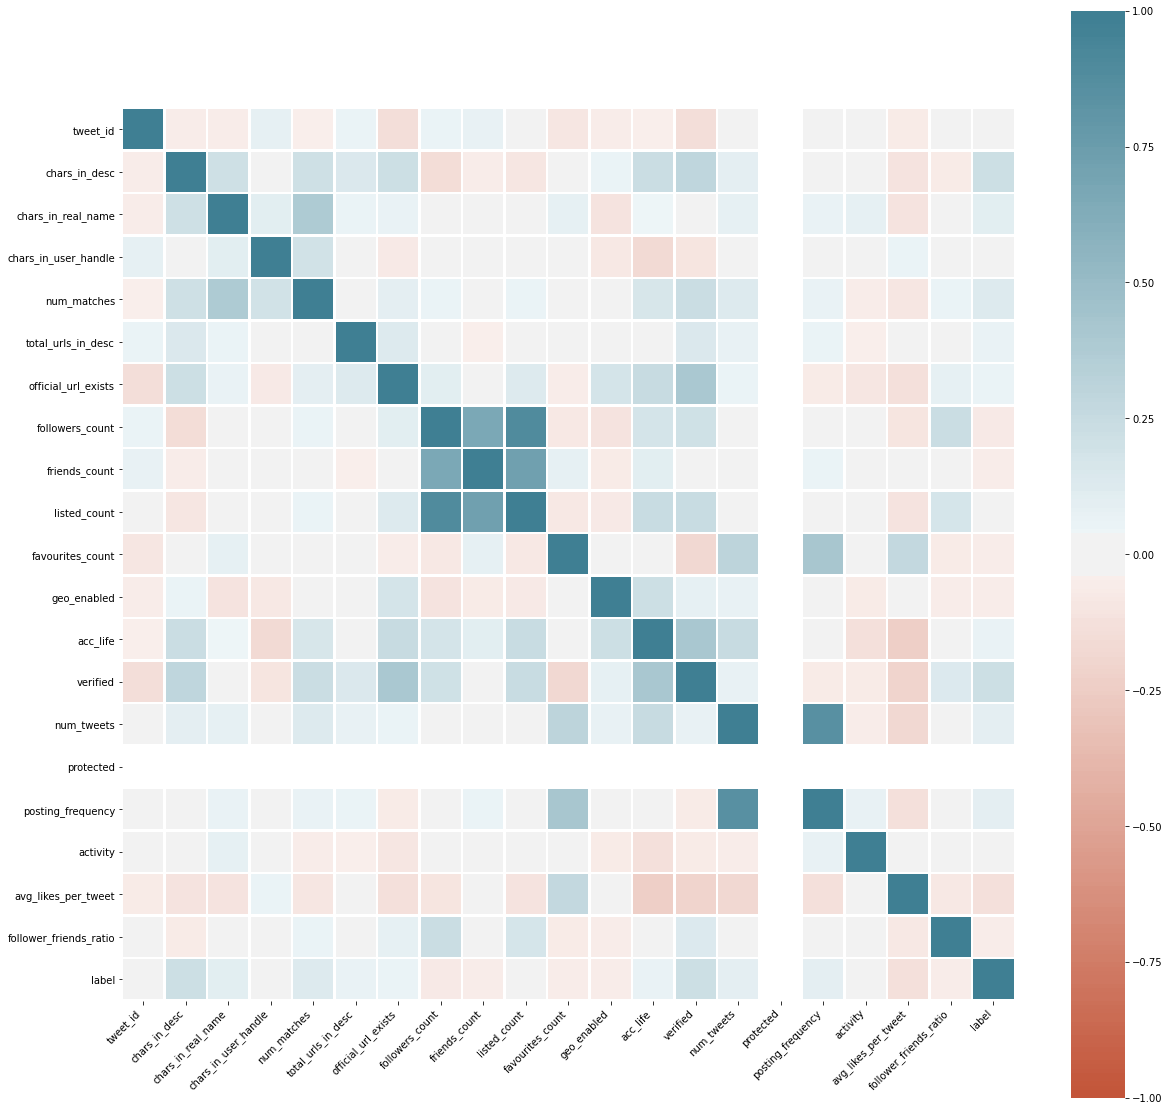

In [120]:
#Correlation Plots
import seaborn as sns

corr = users_df.corr()
fig, ax = plt.subplots(figsize=(20,20))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0, linewidths=1.5,
    cmap=sns.diverging_palette(20, 220, n=200),
    # size = abs(corr),
    ax=ax,
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);



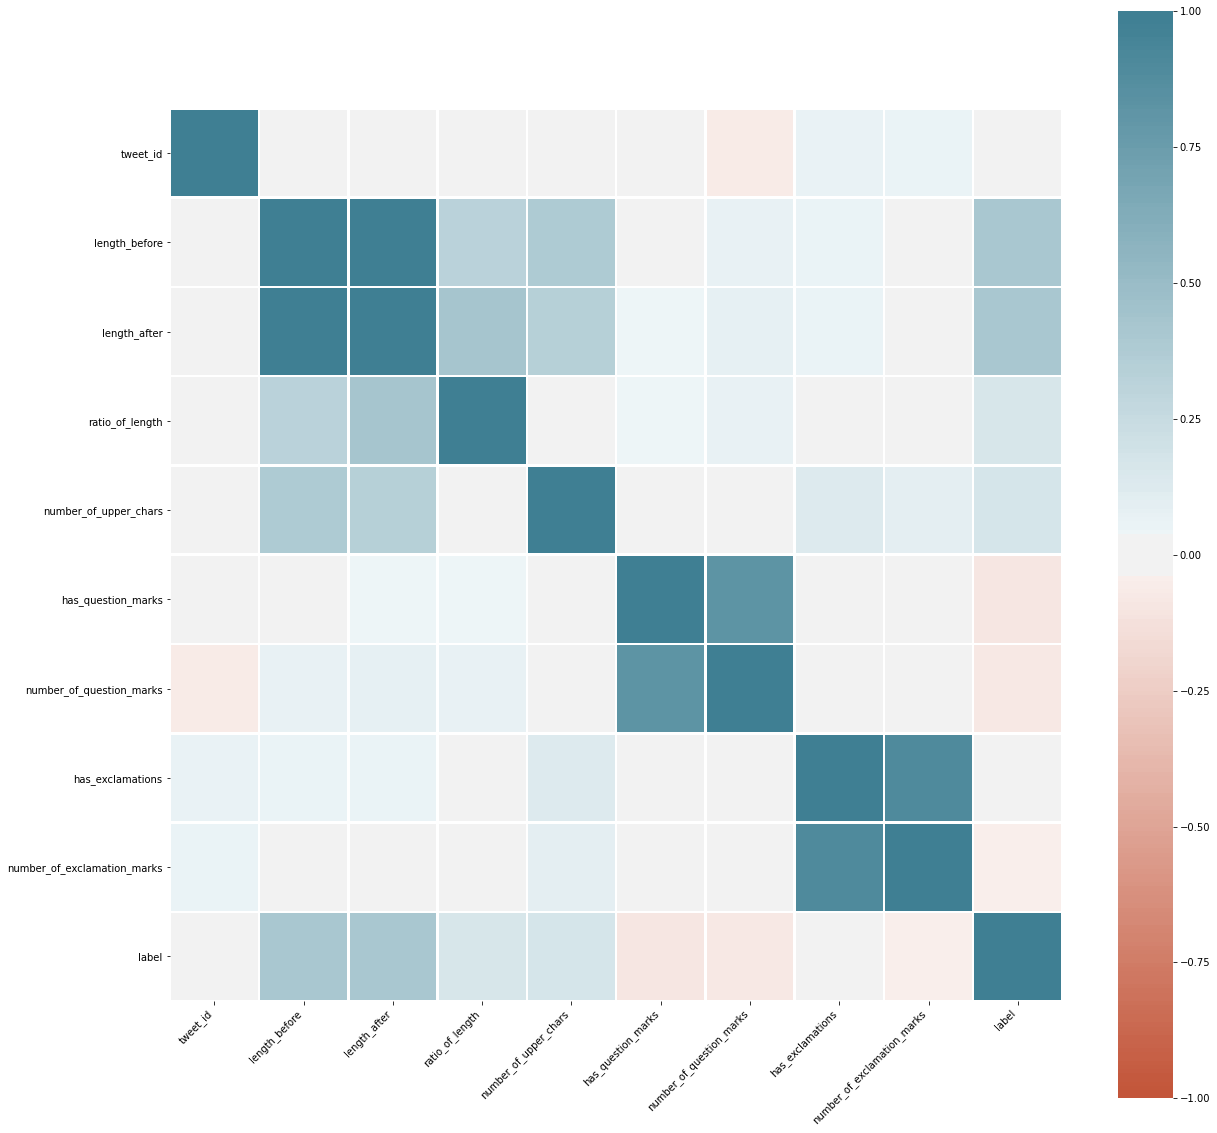

In [121]:
#Correlation Plots
import seaborn as sns

corr = df_en.corr()
fig, ax = plt.subplots(figsize=(20,20))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0, linewidths=1.5,
    cmap=sns.diverging_palette(20, 220, n=200),
    # size = abs(corr),
    ax=ax,
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);



#Extracting Hindi Covid Tweets

In [181]:
a = api.search(q = "#covid",lang='hi', tweet_mode= 'extended', count=100)

hindi_tweets = []
for item in a:
    hindi_tweets.append(item.full_text)
    
df = pd.DataFrame(hindi_tweets,columns = ['hindi_tweets'])
df

,hindi_tweets
0,RT @PeepingMoon: तीन महीने बाद #KasautiiZindag...
1,dilli se kabhie #COVID19 #COVID nahi jane wal...
2,RT @hemantrajora_: बड़ी खबर : Hindu Rao के डॉक...
3,RT @mungale_vijay: @nsitharaman @DasShaktikant...
4,RT @Madhurendra13: आपदा मे जुगाड़ को अस्पताल क...
...,...
95,"RT @Amitjanhit: उत्तर प्रदेश,\nगुजरात\nमध्य प्..."
96,RT @hemantrajora_: बड़ी खबर : Hindu Rao के डॉक...
97,RT @DuraRamBishnoi: #Covid-19 के खिलाफ लड़ाई म...
98,"RT @Amitjanhit: उत्तर प्रदेश,\nगुजरात\nमध्य प्..."


In [ ]:
df.to_csv('/gdrive/My Drive/2nd Sem/IBM/Covid Project/Dataset/Processed_Datasets/hinid_covid_tweets.csv')

In [183]:
labels_list = []

counter = 0
for item in df['hindi_tweets']:
    print("\n",item)
    a = input("Real or Fake? <--- Press 1 for real and 0 for fake --->: ")
    labels_list.append(a)

    counter = counter + 1
    if(counter>5):
        break




 RT @PeepingMoon: तीन महीने बाद #KasautiiZindagiiKay2 की शूटिंग हुई री-स्टार्ट,  #Corona के साये के बीच #ParthSamthaan ने की सेट पर वापसी

@…
Real or Fake? <--- Press 1 for real and 0 for fake --->: 1

 dilli se kabhie #COVID19 #COVID  nahi jane wala kyonki yahan bjp aur aap ki politics kabhie nahi khatm hone wali hai....!

#GalwanValley de diya ANPADH BC ne..
Real or Fake? <--- Press 1 for real and 0 for fake --->: 0

 RT @hemantrajora_: बड़ी खबर : Hindu Rao के डॉक्टर हड़ताल पर जाने की तैयारी में। HRH आज से कोविड अस्पताल के रूप में शुरू हो रहा है।  डॉक्टर…
Real or Fake? <--- Press 1 for real and 0 for fake --->: 1

 RT @mungale_vijay: @nsitharaman @DasShaktikanta  क्यों आपकी अंतरात्मा आपको नहीं  झंझोड़ती?#PMCBankCrisis ने जिंदगी तबाह कर दी हमारी।@republ…
Real or Fake? <--- Press 1 for real and 0 for fake --->: 2

 RT @Madhurendra13: आपदा मे जुगाड़ को अस्पताल कहने वाले @AamAadmiParty के स्वास्थ्य मंत्री प्राइवेट हॉस्पिटल में इलाज कराके लौटें है। 
बाबा…
Real or Fake? <--- Press 1 for r

#Extracting Bangla Covid Tweets

In [ ]:
a = api.search(q = "#covid",lang='hi', tweet_mode= 'extended', count=100)

hindi_tweets = []
for item in a:
    hindi_tweets.append(item.full_text)
    
df = pd.DataFrame(hindi_tweets,columns = ['hindi_tweets'])
df